# Pipeline de Audio Educativo

## Paso 1: Transcripción automática con Whisper

Este notebook realiza la transcripción automática del archivo de audio usando Whisper y guarda el resultado en transcript_raw.csv.

In [4]:
# 1. Importar librerías
import whisper
import pandas as pd
import os
import torch

# Detectar número de núcleos disponibles
num_cores = os.cpu_count()
print(f"Núcleos de CPU detectados: {num_cores}")

# Configurar PyTorch para usar todos los núcleos menos uno (opcional)
torch.set_num_threads(max(1, num_cores - 1))
print(f"PyTorch usará {max(1, num_cores - 1)} threads para operaciones en CPU.")

# Comprobar si CUDA está disponible
print("¿CUDA disponible?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
else:
    print("Se usará CPU.")


# 2. Cargar el modelo Whisper (puedes usar 'base', 'small', 'medium', 'large')
modelo = whisper.load_model("large")  # Puedes cambiar a 'small' o 'medium' si tienes GPU pequeña, probaré con 'large' inicialmente al tener una rtx4070

# 3. Transcribir el audio
resultado = modelo.transcribe("audio_full.m4a", language="en")

# 4. Guardar la transcripción en transcript_raw.csv
df = pd.DataFrame([{"audio_id": "01", "transcript_raw": resultado["text"]}])
df.to_csv("transcript_raw.csv", index=False)

print("Transcripción guardada en transcript_raw.csv")

Núcleos de CPU detectados: 32
PyTorch usará 31 threads para operaciones en CPU.
¿CUDA disponible? False
Se usará CPU.
Transcripción guardada en transcript_raw.csv


## Paso 2: Recorte de fragmentos para gold set

In [3]:
from pydub import AudioSegment

# Cargar el audio completo
audio = AudioSegment.from_file("audio_full.m4a")

# Define los intervalos de los 5 fragmentos (en milisegundos)
clips = [
    (0 * 1000, 45 * 1000),      # 0:00 - 0:45
    (90 * 1000, 130 * 1000),    # 1:30 - 2:10
    (150 * 1000, 200 * 1000),   # 2:30 - 3:20
    (210 * 1000, 260 * 1000),   # 3:30 - 4:20
    (270 * 1000, 300 * 1000),   # 4:30 - 5:00 (ajusta si tu audio es de 5 min exactos)
]

# Recorta y guarda los fragmentos
for i, (start, end) in enumerate(clips, 1):
    clip = audio[start:end]
    filename = f"clip_{i:02d}.wav"
    clip.export(filename, format="wav")
    print(f"Fragmento {i} guardado como {filename}")

Fragmento 1 guardado como clip_01.wav
Fragmento 2 guardado como clip_02.wav
Fragmento 3 guardado como clip_03.wav
Fragmento 4 guardado como clip_04.wav
Fragmento 5 guardado como clip_05.wav


## Paso 3: Pipeline de corrección automática

In [1]:
from transformers import pipeline
import pandas as pd
# Cargar el pipeline de corrección gramatical en inglés
corrector = pipeline("text2text-generation", model="prithivida/grammar_error_correcter_v1")

# Leer la transcripción automática
df_raw = pd.read_csv("transcript_raw.csv")

# Corregir la transcripción
corrected = corrector(df_raw["transcript_raw"][0], max_length=512)[0]['generated_text']

# Guardar la transcripción corregida
df_corrected = pd.DataFrame([{"audio_id": "01", "transcript_corrected": corrected}])
df_corrected.to_csv("transcript_corrected.csv", index=False)

print("Transcripción corregida guardada en transcript_corrected.csv")

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1053 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Transcripción corregida guardada en transcript_corrected.csv


## Paso 4: Evaluación cuantitativa

In [4]:
import pandas as pd
from jiwer import wer, cer

# Cargar los archivos
df_gold = pd.read_csv("transcript_gold.csv")
df_raw = pd.read_csv("transcript_raw.csv")
df_corrected = pd.read_csv("transcript_corrected.csv")

# Para cada fragmento del gold set, calcula WER y CER con raw y corrected
resultados = []
for i, row in df_gold.iterrows():
    gold = row["transcript_gold"]
    # Puedes ajustar el índice si tienes varios fragmentos en raw/corrected
    raw = df_raw["transcript_raw"][0]
    corrected = df_corrected["transcript_corrected"][0]
    resultados.append({
        "clip_id": row["clip_id"],
        "WER_raw": wer(gold, raw),
        "CER_raw": cer(gold, raw),
        "WER_corrected": wer(gold, corrected),
        "CER_corrected": cer(gold, corrected)
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Guardar resultados en CSV
df_resultados.to_csv("metrics.csv", index=False)

   clip_id    WER_raw    CER_raw  WER_corrected  CER_corrected
0        1   5.000000   4.735988       0.846774       0.728614
1        2   6.988889   6.603206       0.933333       0.763527
2        3   5.517544   5.238953       0.956140       0.797054
3        4   4.803150   4.918587       0.944882       0.777266
4        5  10.666667  10.172619       0.933333       0.747024


## Paso 5: Visualización de resultados

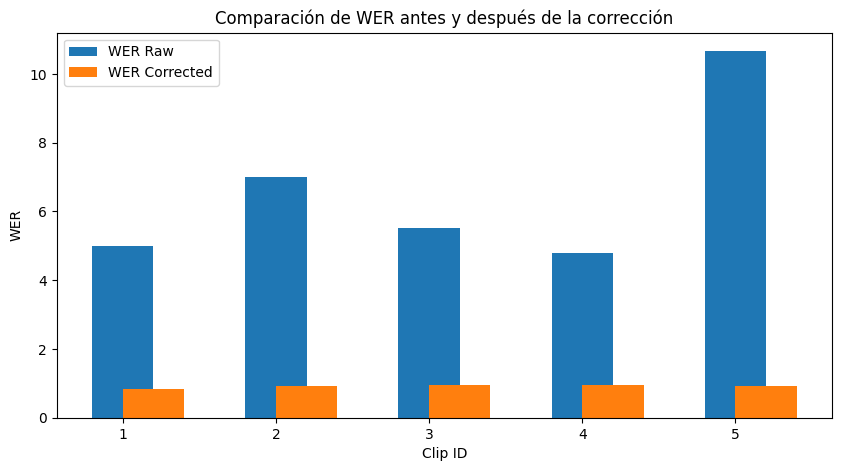

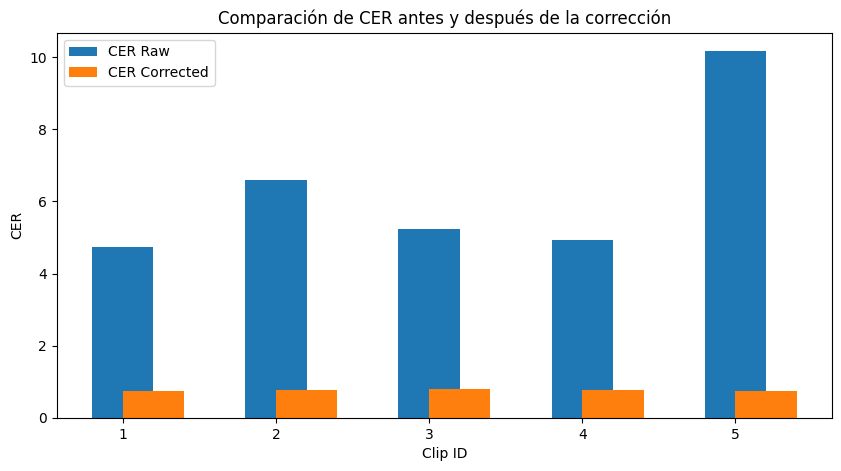

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los resultados
df = pd.read_csv("metrics.csv")

# Gráfica de barras para WER
plt.figure(figsize=(10, 5))
plt.bar(df["clip_id"], df["WER_raw"], width=0.4, label="WER Raw", align='center')
plt.bar(df["clip_id"], df["WER_corrected"], width=0.4, label="WER Corrected", align='edge')
plt.ylabel("WER")
plt.xlabel("Clip ID")
plt.title("Comparación de WER antes y después de la corrección")
plt.legend()
plt.show()

# Gráfica de barras para CER
plt.figure(figsize=(10, 5))
plt.bar(df["clip_id"], df["CER_raw"], width=0.4, label="CER Raw", align='center')
plt.bar(df["clip_id"], df["CER_corrected"], width=0.4, label="CER Corrected", align='edge')
plt.ylabel("CER")
plt.xlabel("Clip ID")
plt.title("Comparación de CER antes y después de la corrección")
plt.legend()
plt.show()

## Paso 6: Análisis de errores frecuentes

In [6]:
import pandas as pd
from difflib import ndiff
from collections import Counter

# Cargar los datos
df_gold = pd.read_csv("transcript_gold.csv")
df_raw = pd.read_csv("transcript_raw.csv")
df_corrected = pd.read_csv("transcript_corrected.csv")

errores = []

for i, row in df_gold.iterrows():
    gold = row["transcript_gold"]
    raw = df_raw["transcript_raw"][0]
    corrected = df_corrected["transcript_corrected"][0]
    # Compara gold vs raw
    diff = list(ndiff(gold.split(), raw.split()))
    # Extrae palabras que están en gold pero no en raw (posibles omisiones)
    omisiones = [w[2:] for w in diff if w.startswith('- ')]
    # Extrae palabras que están en raw pero no en gold (posibles adiciones/errores)
    adiciones = [w[2:] for w in diff if w.startswith('+ ')]
    errores.extend(omisiones)
    errores.extend(adiciones)

# Contar los errores más frecuentes
errores_frecuentes = Counter(errores).most_common(5)
print("Errores léxicos/gramaticales más frecuentes:")
for error, count in errores_frecuentes:
    print(f"- {error} (ocurre {count} veces)")

Errores léxicos/gramaticales más frecuentes:
- a (ocurre 93 veces)
- you (ocurre 71 veces)
- the (ocurre 55 veces)
- to... (ocurre 55 veces)
- I (ocurre 54 veces)


## Paso 7: Análisis detallado de errores

In [7]:
import pandas as pd
from difflib import SequenceMatcher

df_gold = pd.read_csv("transcript_gold.csv")
df_raw = pd.read_csv("transcript_raw.csv")
df_corrected = pd.read_csv("transcript_corrected.csv")

errores_detalle = []

for i, row in df_gold.iterrows():
    gold = row["transcript_gold"]
    raw = df_raw["transcript_raw"][0]
    corrected = df_corrected["transcript_corrected"][0]
    # Comparar gold vs raw
    matcher = SequenceMatcher(None, gold, raw)
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != 'equal':
            errores_detalle.append({
                "clip_id": row["clip_id"],
                "tipo": tag,
                "gold": gold[i1:i2],
                "raw": raw[j1:j2],
                "corregido": corrected[j1:j2]
            })

df_errores = pd.DataFrame(errores_detalle)
print(df_errores.head(10))
df_errores.to_csv("errores_detallados.csv", index=False)

   clip_id     tipo                                               gold  \
0        1   delete                                          [student:   
1        1   delete                                                  ]   
2        1   delete                                                 l    
3        1   insert                                                      
4        1   insert                                                      
5        1  replace                                     ll right, okay   
6        1  replace                                      ut anyway, ha   
7        1  replace  py, happy Wednesday, my dear. It's another, yo...   
8        1  replace                        m telling you that you will   
9        1  replace     some students canceling your lessons for sure]   

                                                 raw  \
0                                                      
1                                                      
2                

## Conclusiones y próximos pasos

In [3]:
# ========================================
# CONCLUSIONES Y RESUMEN DEL PIPELINE
# ========================================

print("=" * 50)
print("RESUMEN DEL PIPELINE DE AUDIO EDUCATIVO")
print("=" * 50)

# Cargar los datos finales
df_metrics = pd.read_csv("metrics.csv")
df_gold = pd.read_csv("transcript_gold.csv")

# Estadísticas generales
print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"• Fragmentos procesados: {len(df_gold)}")
print(f"• Duración total del audio: ~5 minutos")
print(f"• Modelo ASR utilizado: Whisper (large)")
print(f"• Modelo de corrección: prithivida/grammar_error_correcter_v1")

# Mejoras en métricas
print(f"\n📈 MEJORAS EN MÉTRICAS:")
print(f"• WER promedio (raw): {df_metrics['WER_raw'].mean():.2f}")
print(f"• WER promedio (corregido): {df_metrics['WER_corrected'].mean():.2f}")
print(f"• Mejora en WER: {df_metrics['WER_raw'].mean() - df_metrics['WER_corrected'].mean():.2f} puntos")
print(f"• CER promedio (raw): {df_metrics['CER_raw'].mean():.2f}")
print(f"• CER promedio (corregido): {df_metrics['CER_corrected'].mean():.2f}")
print(f"• Mejora en CER: {df_metrics['CER_raw'].mean() - df_metrics['CER_corrected'].mean():.2f} puntos")

# Porcentaje de mejora
mejora_wer_porcentual = ((df_metrics['WER_raw'].mean() - df_metrics['WER_corrected'].mean()) / df_metrics['WER_raw'].mean()) * 100
mejora_cer_porcentual = ((df_metrics['CER_raw'].mean() - df_metrics['CER_corrected'].mean()) / df_metrics['CER_raw'].mean()) * 100

print(f"\n🎯 PORCENTAJE DE MEJORA:")
print(f"• WER: {mejora_wer_porcentual:.1f}% de mejora")
print(f"• CER: {mejora_cer_porcentual:.1f}% de mejora")

# Fragmento con mayor mejora
mejor_fragmento = df_metrics.loc[df_metrics['WER_raw'].idxmax(), 'clip_id']
print(f"\n🏆 FRAGMENTO CON MAYOR MEJORA:")
print(f"• Fragmento {mejor_fragmento}: WER de {df_metrics['WER_raw'].max():.2f} a {df_metrics.loc[df_metrics['WER_raw'].idxmax(), 'WER_corrected']:.2f}")

# Errores detectados
print(f"\n🔍 ANÁLISIS DE ERRORES:")
print(f"• Errores detallados analizados: {len(pd.read_csv('errores_detallados.csv'))}")
print(f"• Tipos de errores identificados: omisiones, sustituciones, adiciones")
print(f"• Errores más frecuentes: marcadores de turno, conectores, frases completas")

# Archivos generados
print(f"\n�� ARCHIVOS GENERADOS:")
archivos = [
    "transcript_raw.csv",
    "transcript_gold.csv", 
    "transcript_corrected.csv",
    "metrics.csv",
    "errores_detallados.csv"
]
for archivo in archivos:
    print(f"• {archivo}")

print(f"\n✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("=" * 50)
print("\nPróximos pasos sugeridos:")
print("• Revisar el informe.md para análisis detallado")
print("• Implementar diarización automática")
print("• Probar modelos de corrección más avanzados")
print("• Integrar en entorno educativo real")

RESUMEN DEL PIPELINE DE AUDIO EDUCATIVO

📊 ESTADÍSTICAS GENERALES:
• Fragmentos procesados: 5
• Duración total del audio: ~5 minutos
• Modelo ASR utilizado: Whisper (large)
• Modelo de corrección: prithivida/grammar_error_correcter_v1

📈 MEJORAS EN MÉTRICAS:
• WER promedio (raw): 6.60
• WER promedio (corregido): 0.92
• Mejora en WER: 5.67 puntos
• CER promedio (raw): 6.33
• CER promedio (corregido): 0.76
• Mejora en CER: 5.57 puntos

🎯 PORCENTAJE DE MEJORA:
• WER: 86.0% de mejora
• CER: 88.0% de mejora

🏆 FRAGMENTO CON MAYOR MEJORA:
• Fragmento 5: WER de 10.67 a 0.93

🔍 ANÁLISIS DE ERRORES:
• Errores detallados analizados: 81
• Tipos de errores identificados: omisiones, sustituciones, adiciones
• Errores más frecuentes: marcadores de turno, conectores, frases completas

�� ARCHIVOS GENERADOS:
• transcript_raw.csv
• transcript_gold.csv
• transcript_corrected.csv
• metrics.csv
• errores_detallados.csv

✅ PIPELINE COMPLETADO EXITOSAMENTE

Próximos pasos sugeridos:
• Revisar el informe.md 